In [69]:
import os

import nibabel as nib
import numpy as np
import ants
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import exposure

import matplotlib.pyplot as plt

In [25]:
def plot_slices(image, title=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    slices = [image[image.shape[0] // 2, :, :], 
              image[:, image.shape[1] // 2, :], 
              image[:, :, image.shape[2] // 2]]
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap='gray')
        axes[i].axis('off')
    if title:
        fig.suptitle(title)
    plt.show()

In [21]:
def fix_orientation(fus_path, output_path):
    # Load the fUS image
    fus_img = nib.load(fus_path)

    fus_data = fus_img.get_fdata()
    fus_affine = fus_img.affine
    
    # Define the corrected transformation matrix from LAS to RAS
    las_to_ras = np.array([[-1, 0, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
    
    # Apply the RAS to PLI transformation to the fUS affine
    transformed_fus_affine = las_to_ras @ fus_affine
    
    # Flip the z-axis on fUS data, which has wrong orientation on z-axis
    reoriented_data = np.flip(fus_data, axis=2)
    
    # Save the new fUS image with the adjusted affine
    new_fus_img = nib.Nifti1Image(reoriented_data, transformed_fus_affine, fus_img.header)
    nib.save(new_fus_img, output_path)
    
    print(f"Adjusted affine fUS image saved to {output_path}")


# Paths to the fUS, MRA, and output images
fus_path = '../data/0527/fusi.nii'
output_path = '../data/0527/fusi_corrected.nii.gz'

fix_orientation(fus_path, output_path)


pixdim[1,2,3] should be positive; setting to abs of pixdim values


Adjusted affine fUS image saved to ../data/0527/fusi_corrected.nii.gz


In [70]:
def preprocess_images(fus_path, mra_path, output_fus_path, output_mra_path):
    # Load images using ANTsPy
    fus_img = ants.image_read(fus_path)
    mra_img = ants.image_read(mra_path)

    # Normalize the fUS image to [0, 1]
    fus_data = fus_img.numpy()
    fus_normalized_data = (fus_data - np.min(fus_data)) / (np.max(fus_data) - np.min(fus_data))
    fus_normalized = ants.from_numpy(fus_normalized_data, origin=fus_img.origin, spacing=fus_img.spacing, direction=fus_img.direction)

    # Apply bias field correction to MRA
    mra_corrected = ants.n4_bias_field_correction(mra_img)

    # Normalize the MRA image to [0, 1]
    mra_data = mra_corrected.numpy()
    mra_normalized_data = (mra_data - np.min(mra_data)) / (np.max(mra_data) - np.min(mra_data))
    mra_normalized = ants.from_numpy(mra_normalized_data, origin=mra_corrected.origin, spacing=mra_corrected.spacing, direction=mra_corrected.direction)

    # Save preprocessed images
    ants.image_write(fus_normalized, output_fus_path)
    ants.image_write(mra_normalized, output_mra_path)

    print(f"Preprocessed images saved to {output_fus_path} and {output_mra_path}")

In [71]:
fus_path = '../data/0527/fusi_corrected.nii.gz'
mra_path = '../data/0527/angio.nii.gz'
output_fus_path = '../data/0527/fusi_corrected_preprocessed.nii.gz'
output_mra_path = '../data/0527/angio_preprocessed.nii.gz'

preprocess_images(fus_path, mra_path, output_fus_path, output_mra_path)

Preprocessed images saved to ../data/0527/fusi_corrected_preprocessed.nii.gz and ../data/0527/angio_preprocessed.nii.gz


In [72]:
def perform_registration(fus_path, mra_path, output_prefix, transform_type, metric='CC', iterations='1000x500x250x100', gradient_step=0.1, flow_sigma=3, total_sigma=0, mask_path=None):
    try:
        # Load preprocessed fUS and MRA images using ANTsPy
        fus_img = ants.image_read(fus_path)
        mra_img = ants.image_read(mra_path)

        # Load or create a mask if provided
        mask = ants.image_read(mask_path) if mask_path else None

        # Determine the registration iterations based on the transform type
        if transform_type == 'SyN':
            reg_iterations = '2000x1000x500x250'
        else:
            reg_iterations = iterations

        # Perform registration
        transform = ants.registration(
            fixed=mra_img, 
            moving=fus_img, 
            type_of_transform=transform_type,
            metric=metric,
            reg_iterations=reg_iterations,
            gradient_step=gradient_step,
            flow_sigma=flow_sigma,
            total_sigma=total_sigma,
            verbose=True,
            mask=mask
        )
        
        # Save the registered image
        registered_fus = transform['warpedmovout']
        if mask_path:
            output_file = f"{output_prefix}_{metric.lower()}_{transform_type.lower()}_masked.nii.gz"
        else:
            output_file = f"{output_prefix}_{metric.lower()}_{transform_type.lower()}.nii.gz"
        ants.image_write(registered_fus, output_file)
        
        print(f"Registered fUS image saved to {output_file}")
    
    except Exception as e:
        print(f"Registration failed with error: {e}")

In [75]:
# Paths to preprocessed images and mask
fus_path = '../data/0527/fusi_corrected_preprocessed.nii.gz'
mra_path = '../data/0527/angio_preprocessed.nii.gz'
mask_path = '../data/0527/mask_brain.nii.gz'  # Optional, only used for masked registration

# Output prefix for results
output_prefix = '../data/0527/fusi_processed_ants'
metric = 'CC'
# 1. Rigid Registration
perform_registration(fus_path, mra_path, output_prefix, 'Rigid', metric=metric)

# 2. Affine Registration
perform_registration(fus_path, mra_path, output_prefix, 'Affine', metric=metric)

# 3. SyN Registration
# perform_registration(fus_path, mra_path, output_prefix, 'SyN')

# 4. Masked Rigid Registration
perform_registration(fus_path, mra_path, output_prefix, 'Rigid', metric=metric, mask_path=mask_path)

# 5. Masked Affine Registration
perform_registration(fus_path, mra_path, output_prefix, 'Affine', metric=metric, mask_path=mask_path)

# 6. Masked SyN Registration
# perform_registration(fus_path, mra_path, output_prefix, 'SyN', mask_path=mask_path)


antsRegistration -d 3 -r [0x111e056e0,0x3e2bc0790,1] -m mattes[0x111e056e0,0x3e2bc0790,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [/var/folders/xh/0b2t8trn63n0nz_9qb97s_940000gn/T/tmp9xr0yppf,0x3e2eee4a0,0x3e723fc60] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass alignment using fixed image: 0x111e056e0 and moving image: 0x3e2bc0790 (type = Euler3DTransform)
  Reading mask(s).
    Registration stage 0
      No fixed mask
      No moving mask
  number of levels = 4
  fixed image: 0x111e056e0
  moving image: 0x3e2bc0790
Dimension = 3
Number of stages = 1
Use histogram matching = true
Winsorize image intensities = false
  Lower quantile = 0.0000e+00
  Upper quantile = 1.0000e+00


Stage 1 State
   Image metric = Mattes
     Fixed image = Image (0x3d8c55710)
  RTTI typeinfo:   itk::Im

In [77]:
def perform_syn_registration(fus_path, mra_path, output_prefix, metric='MI', mask_path=None):
    try:
        # Load preprocessed fUS and MRA images using ANTsPy
        fus_img = ants.image_read(fus_path)
        mra_img = ants.image_read(mra_path)

        # Load or create a mask if provided
        mask = ants.image_read(mask_path) if mask_path else None

        # Perform SyN registration
        transform = ants.registration(
            fixed=mra_img, 
            moving=fus_img, 
            type_of_transform='SyN',
            metric=metric,
            reg_iterations=(2000, 1000, 500, 250),  # Simplified iterations
            gradient_step=0.1,
            flow_sigma=3,
            total_sigma=0,
            verbose=True,
            mask=mask
        )
        
        # Save the registered image
        registered_fus = transform['warpedmovout']
        if mask_path:
            output_file = f"{output_prefix}_{metric.lower()}_syn_masked.nii.gz"
        else:
            output_file = f"{output_prefix}_{metric.lower()}_syn.nii.gz"
        ants.image_write(registered_fus, output_file)
        
        print(f"Registered fUS image saved to {output_file}")
    
    except Exception as e:
        print(f"Registration failed with error: {e}")

metric = 'CC'
perform_syn_registration(fus_path, mra_path, output_prefix, metric=metric)
perform_syn_registration(fus_path, mra_path, output_prefix, metric=metric, mask_path=mask_path)

antsRegistration -d 3 -r [0x3cdad3e10,0x3e4deed20,1] -m mattes[0x3cdad3e10,0x3e4deed20,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x0 -s 3x2x1x0 -f 4x2x2x1 -x [NA,NA] -m mattes[0x3cdad3e10,0x3e4deed20,1,32] -t SyN[0.200000,3.000000,0.000000] -c [2000x1000x500x250,1e-7,8] -s 3x2x1x0 -f 8x4x2x1 -u 1 -z 1 -o [/var/folders/xh/0b2t8trn63n0nz_9qb97s_940000gn/T/tmp7lc6t5g0,0x3e2b68f70,0x3e2bb34c0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass alignment using fixed image: 0x3cdad3e10 and moving image: 0x3e4deed20 (type = Euler3DTransform)
  Reading mask(s).
    Registration stage 0
      No fixed mask
      No moving mask
    Registration stage 1
      No fixed mask
      No moving mask
  number of levels = 4
  number of levels = 4
  fixed image: 0x3cdad3e10
  moving image: 0x3e4deed20
  fixed image: 0x3cdad3e10
  moving imag

In [3]:
import numpy as np
import nibabel as nib
from scipy.ndimage import gaussian_filter
from skimage.filters import frangi, sato
from skimage.exposure import equalize_adapthist, rescale_intensity

In [5]:
import matplotlib.pyplot as plt

def plot_slices(image, title=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    slices = [image[image.shape[0] // 2, :, :], 
              image[:, image.shape[1] // 2, :], 
              image[:, :, image.shape[2] // 2]]
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap='gray')
        axes[i].axis('off')
    if title:
        fig.suptitle(title)
    plt.show()

In [6]:
fus_path = '../data/0524/fus_in_angio_space_centered.nii.gz'
mra_path = '../data/0524/angio_centered.nii.gz'

fus_image = nib.load(fus_path)
mra_image = nib.load(mra_path)

fus_data = fus_image.get_fdata()
mra_data = mra_image.get_fdata()

# Ensure the images are of type float32
fus_data = fus_data.astype(np.float32)
mra_data = mra_data.astype(np.float32)

In [7]:
import numpy as np
from scipy.ndimage import zoom

# Assuming fus_image and mra_image are your functional ultrasound and MRA images respectively

# Voxel sizes
fus_spacing = np.array(fus_image.header.get_zooms())
mra_spacing = np.array(mra_image.header.get_zooms())

# Compute the zoom factors
zoom_factors = mra_spacing / fus_spacing

# Resample the MRA image to match the fUS voxel sizes
resampled_mra = zoom(mra_data, zoom=zoom_factors, order=1)

# save the resampled MRA image
nib.save(nib.Nifti1Image(resampled_mra, mra_image.affine), '../data/0524/angio_centered_resampled.nii.gz')

# Now both images have the same voxel sizes

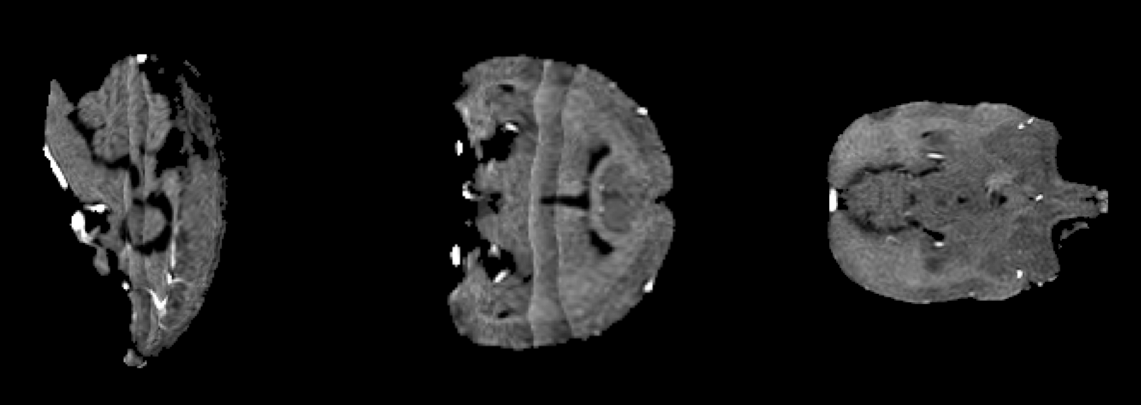

In [8]:
plot_slices(mra_data)

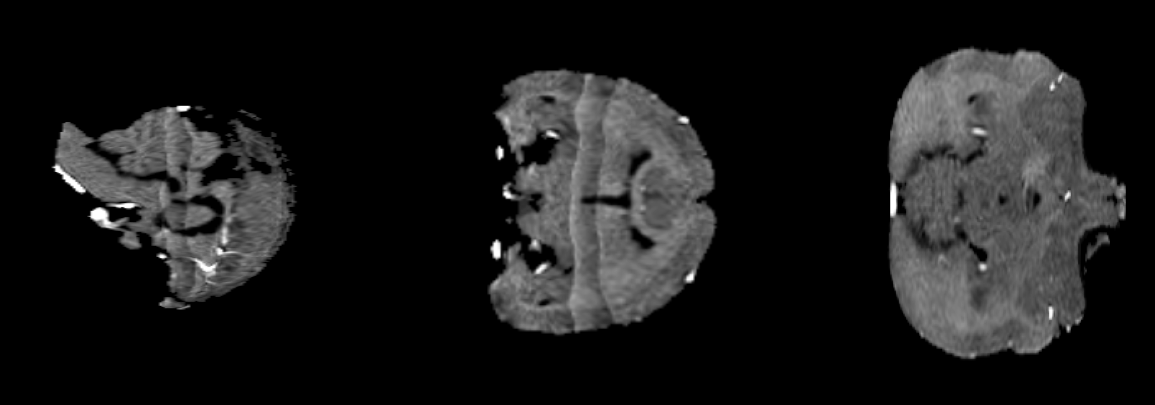

In [9]:
plot_slices(resampled_mra)

In [10]:
def pad_or_crop_image_sym(image, target_shape):
    """
    Pad or crop an image symmetrically around its center to match the target shape.
    """
    padded_image = np.zeros(target_shape, dtype=image.dtype)
    current_shape = np.array(image.shape)
    start_indices = ((target_shape - current_shape) // 2).astype(int)

    slices_src = tuple(slice(max(0, -start), min(dim, dim + min(0, start))) for start, dim in zip(start_indices, current_shape))
    slices_dst = tuple(slice(max(0, start), start + (src.stop - src.start)) for start, src in zip(start_indices, slices_src))

    padded_image[slices_dst] = image[slices_src]
    return padded_image

In [11]:
resampled_mra.shape, fus_data.shape

((267, 200, 274), (192, 151, 173))

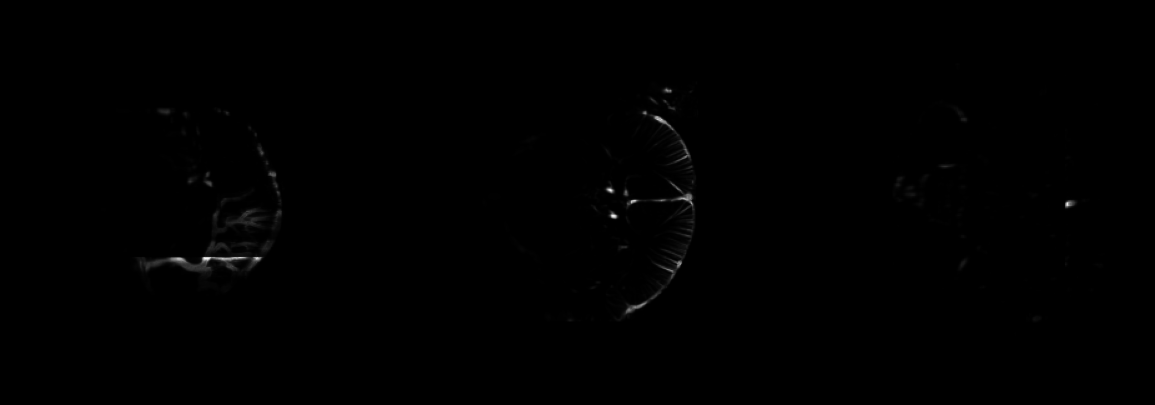

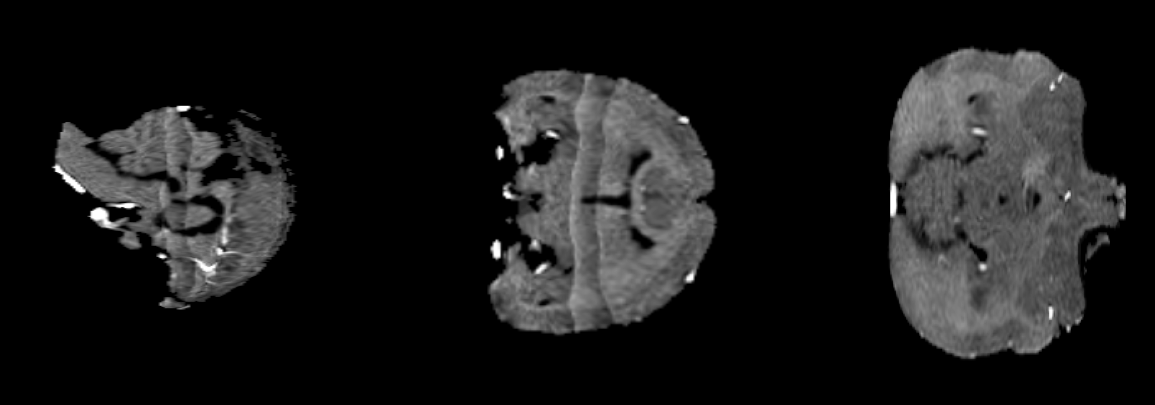

In [12]:
# Pad or crop images to the same shape
target_shape = np.maximum(resampled_mra.shape, fus_data.shape)
resampled_mra_padded = pad_or_crop_image_sym(resampled_mra, target_shape)
fus_padded = pad_or_crop_image_sym(fus_data, target_shape)

# save the padded images
nib.save(nib.Nifti1Image(fus_padded, fus_image.affine), '../data/0524/fus_in_angio_space_centered_padded.nii.gz')
nib.save(nib.Nifti1Image(resampled_mra_padded, mra_image.affine), '../data/0524/angio_centered_resampled_padded.nii.gz')

plot_slices(fus_padded)
plot_slices(resampled_mra_padded)

In [13]:
fus_padded.shape, resampled_mra_padded.shape

((267, 200, 274), (267, 200, 274))

In [14]:
# Normalize the images
mra_norm = (resampled_mra_padded - np.min(resampled_mra_padded)) / (np.max(resampled_mra_padded) - np.min(resampled_mra_padded))
fus_norm = (fus_padded - np.min(fus_padded)) / (np.max(fus_padded) - np.min(fus_padded))

# save the normalized images
nib.save(nib.Nifti1Image(mra_norm, mra_image.affine), '../data/0524/angio_centered_resampled_padded_normalized.nii.gz')
nib.save(nib.Nifti1Image(fus_norm, fus_image.affine), '../data/0524/fus_in_angio_space_centered_padded_normalized.nii.gz')

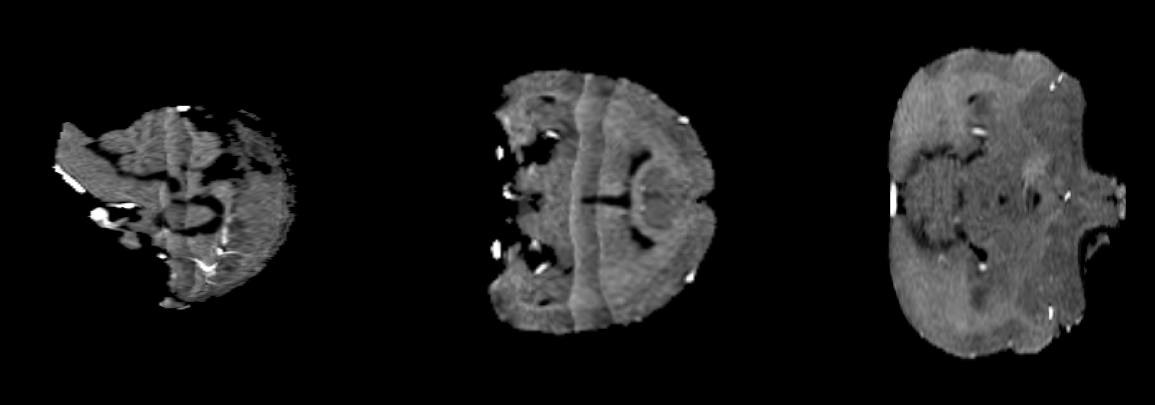

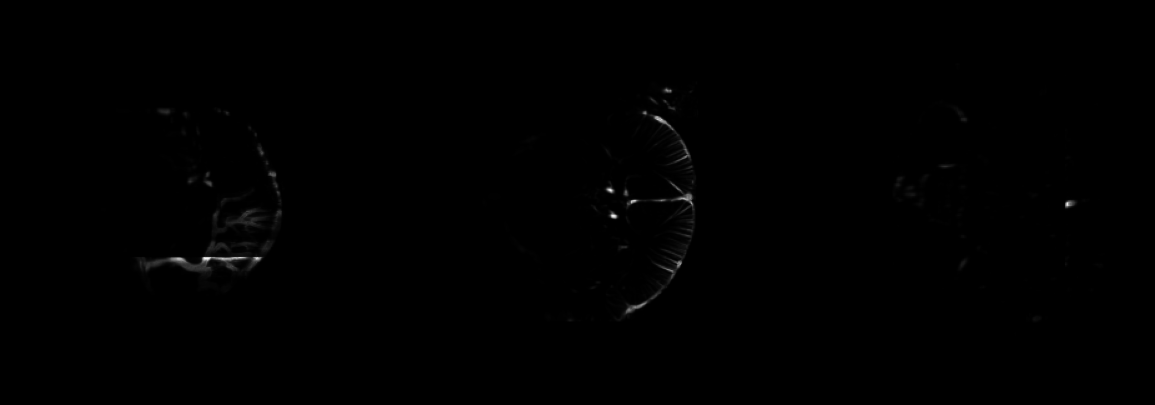

(None, None)

In [123]:
plot_slices(mra_norm), plot_slices(fus_norm)

In [3]:
import numpy as np
import nibabel as nib
from dipy.align.imaffine import MutualInformationMetric, AffineRegistration
from dipy.align.transforms import RigidTransform3D, AffineTransform3D

mra_norm = nib.load("../data/0524/angio_centered_resampled_padded_normalized.nii.gz").get_fdata()
fus_norm = nib.load("../data/0524/fus_in_angio_space_centered_padded_normalized.nii.gz").get_fdata()

# Adjusted metric parameters
metric = MutualInformationMetric(nbins=64, sampling_proportion=0.3)  # Increased nbins, slightly adjusted sampling proportion

# Adjusted level iterations
level_iters = [2000, 1500, 1000, 500]  # Added an additional level for finer control

# Adjusted sigmas
sigmas = [3.0, 2.0, 1.0, 0.5]  # Added an additional level for finer control

# Adjusted factors
factors = [4, 3, 2, 1]

affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)

# Experiment with different transforms
transform = RigidTransform3D()  # You can also try AffineTransform3D

params0 = None

affine_map = affreg.optimize(static=mra_norm, moving=fus_norm, transform=transform, params0=params0)
registered_image = affine_map.transform(fus_norm)

# Optional: Apply post-processing to the registered image
# For example, apply a Gaussian filter to smooth the registered image
import scipy.ndimage as ndimage

registered_image_smooth = ndimage.gaussian_filter(registered_image, sigma=1)


Optimizing level 3 [max iter: 2000]
Optimizing level 2 [max iter: 1500]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 500]


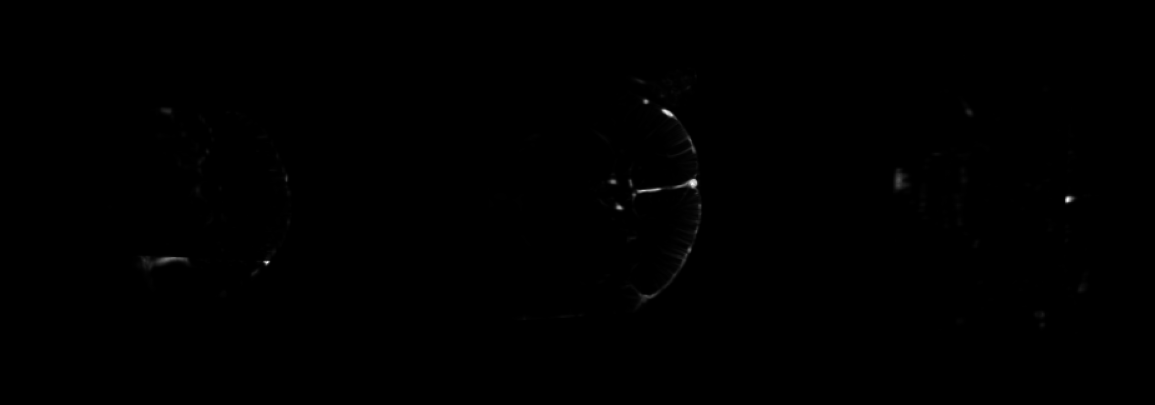

In [6]:
plot_slices(registered_image)

In [11]:
affine_map.affine

array([[ 9.96795347e-01, -4.00239693e-02,  6.92612328e-02,
         3.14419154e-04],
       [ 4.29880219e-02,  9.98198803e-01, -4.18471028e-02,
         3.15184249e-04],
       [-6.74615925e-02,  4.46904008e-02,  9.96720473e-01,
         3.15279145e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [144]:
output_path = '../data/0524/fus_in_angio_space_centered_padded_registered.nii.gz'
nib.save(nib.Nifti1Image(registered_image, affine_map.affine), output_path)

In [7]:
import matplotlib.pyplot as plt

def plot_overlay(image1, image2, slice_idx):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(image1[:, slice_idx, :], cmap='gray')
    ax[0].set_title('Reference Image')
    
    ax[1].imshow(image2[:, slice_idx, :], cmap='gray')
    ax[1].set_title('Registered Image')
    
    ax[2].imshow(image1[:, slice_idx, :], cmap='gray', alpha=0.5)
    ax[2].imshow(image2[:, slice_idx, :], cmap='hot', alpha=0.5)
    ax[2].set_title('Overlay')
    
    plt.show()

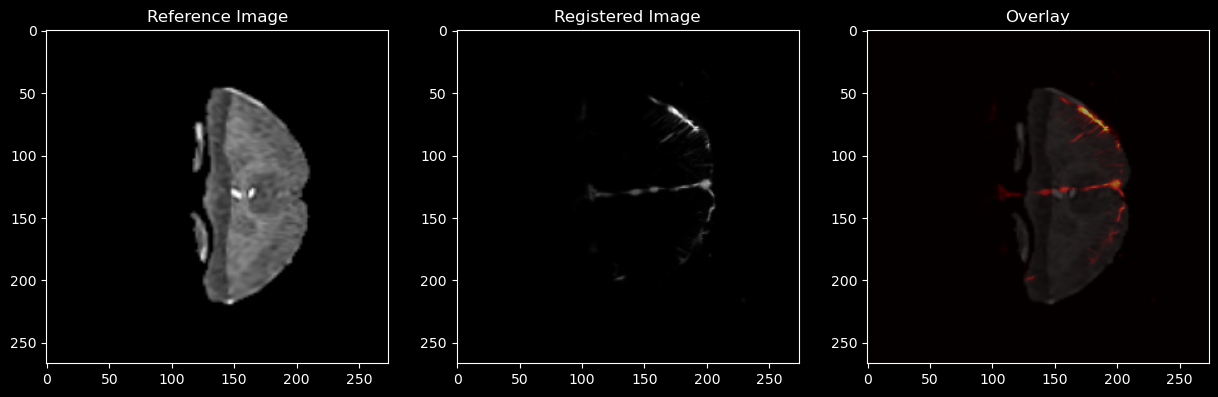

In [10]:
plot_overlay(mra_norm, registered_image, slice_idx=150)

In [145]:
image_path = '../data/0524/fus_in_angio_space_centered_padded_registered.nii.gz'
output_path = '../data/0524/fus_in_angio_space_centered_padded_registered_centered.nii.gz'
center_image(image_path, output_path)

In [15]:
mra_path = '../data/0524/angio_centered_resampled_padded_normalized.nii.gz'
fus_path = '../data/0524/fus_in_angio_space_centered_padded_registered_centered.nii.gz'

In [18]:
import ants

fixed = ants.image_read(mra_path)
moving = ants.image_read(fus_path)

# Perform rigid registration as a pre-step
rigid = ants.registration(fixed=fixed, moving=moving, type_of_transform='Rigid')
print("perform rigid registration")
# Use the result of the rigid registration to initialize the next step
rigid_transformed = rigid['warpedmovout']

print("perform affine registration")
# Perform further registration with affine transformation
affine = ants.registration(fixed=fixed, moving=rigid_transformed, type_of_transform='Affine')

# Use the result of the affine registration to initialize the non-linear step
affine_transformed = affine['warpedmovout']

print("perform non-linear registration")
# Perform non-linear registration
# Using 'CC' (Cross-Correlation) as the similarity metric
syn = ants.registration(fixed=fixed, moving=affine_transformed, type_of_transform='SyN',
                        reg_iterations=(100, 70, 50),
                        aff_metric='mattes',
                        syn_metric='CC',
                        syn_sampling=4)

# Get the final registered image
registered_image = syn['warpedmovout']
ants.image_write(registered_image, '../data/0524/registered_fus_image_ants.nii.gz')


perform rigid registration
perform affine registration


In [153]:
import pyelastix as pelx

# Load images
fixed_image = nib.load(mra_path)
moving_image = nib.load(fus_path)

# Get image data and affine
fixed_data = np.ascontiguousarray(fixed_image.get_fdata(), dtype=np.float32)
moving_data = np.ascontiguousarray(moving_image.get_fdata(), dtype=np.float32)
fixed_affine = fixed_image.affine
moving_affine = moving_image.affine

# Define parameters for registration
params = pelx.get_default_params()
params.NumberOfResolutions = 3
params.FinalGridSpacingInPhysicalUnits = 8
params.MaximumNumberOfIterations = 500
params.NumberOfSpatialSamples = 2048

# Perform registration
result = pelx.register(fixed_data, moving_data, params)

# Get registered image and transformation matrix
registered_data = result[0]
transform = result[1]

# Save the registered image
registered_image = nib.Nifti1Image(registered_data, fixed_affine)
nib.save(result_image, '../data/0524/registered_fus_image_elastix.nii')


RuntimeError: Could not find Elastix executable. Download Elastix from http://elastix.isi.uu.nl/. Pyelastix looks for the exe in a series of common locations. Set ELASTIX_PATH if necessary.

In [154]:
import subprocess

# Perform registration using FLIRT (command-line tool)
subprocess.run(['flirt', '-in', '../data/0524/fus_in_angio_space_centered_padded.nii.gz', '-ref', '../data/0524/angio_centered_resampled_padded.nii.gz', '-out', '../data/0524/registered_fus_image_flirt.nii', '-omat', 'fus_to_mra.mat'])

# Check the output files 'registered_fus_image_flirt.nii' and 'fus_to_mra.mat' for the registered image and transformation matrix, respectively.


CompletedProcess(args=['flirt', '-in', '../data/0524/fus_in_angio_space_centered_padded.nii.gz', '-ref', '../data/0524/angio_centered_resampled_padded.nii.gz', '-out', '../data/0524/registered_fus_image_flirt.nii', '-omat', 'fus_to_mra.mat'], returncode=0)